# Pump It Up Data Mining the Water Table

## Content:
1. [Introduction](#first-bullet)
2. [Data Overview](#second-bullet)
    * [Loading Datasets](#second1-bullet)
    * [Changing Data Type](#second2-bullet)
    * [Data Profile](#second3-bullet)
* [Data Cleaning](#third-bullet)
    * [Handeling Outliers](#third1-bullet)
    * [Handeling Missing Values](#third2-bullet)
        * [Binning](#third21-bullet)
        * [Kmode Clustering](#third22-bullet)
        * [Missing Value Imputation](#third23-bullet)
* [Data Exploration](#forth-bullet)
    * [More Data Cleaning](#forth1-bullet)
    * [Dataset Balance](#forth2-bullet)
* [Feature Engineering]
    * [PCA]
* [Modeling]
    * [LDA]
    * [Baseline Model]
    

* `[The Pipeline](#fifth-bullet)


In [1]:
# pip install pandas-profiling[notebook,html]
# pip install kmodes
# pip install --upgrade kmodes

In [2]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import svm

from pandas_profiling import ProfileReport
from kmodes.kmodes import KModes
from sklearn.model_selection import KFold

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

## 1. Introduction <a class="anchor" id="first-bullet"></a>

This project, using data from Taarifa and the Tanzanian Ministry of Water, predicts which water pumps are functional, which need some repairs, and which don't work at all. As such, this is a multi-class classification problem.

The aim is to provide insight as to which waterpoint might fail and which variables are able to strongly predict this to improve maintainace and ensure clean and portable water is available to communities in Tanzania.

## 2. Data Overview 

   ### 2.1. Loading Datasets <a class="anchor" id="second1-bullet"></a>

In [46]:
training_label = pd.read_csv("data/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv")
training_values = pd.read_csv("data/4910797b-ee55-40a7-8668-10efd5c1b960.csv")
test = pd.read_csv("data/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv")

train = training_values.merge(training_label, on = 'id')


test['status_group'] = '*unknown*'#the unknown target variable

#We will annotate our train and test set before combining them for simple indexing later on. 
train['data_set'] = 'train'
test['data_set'] = 'test'

trainset = pd.DataFrame(train)
testset = pd.DataFrame(test)

display(Markdown("There are {} observations in training set, and {} observations in the test set:{} observations in total.".format(len(train), len(test), len(train) + len(test))))
display(Markdown("There are {} variables in training dataset including the target variable.".format(len(train.columns))))

There are 59400 observations in training set, and 14850 observations in the test set:74250 observations in total.

There are 42 variables in training dataset including the target variable.

In [47]:
display(Markdown("Combining test and train set.")) 
dataset = trainset.append(testset)
dataset.head()

Combining test and train set.

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,data_set
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,train
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,train
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,train
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,train
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,train


In [48]:
dataset[:59400].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 42 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

### 2.2. Data Type <a class="anchor" id="second2-bullet"></a>

The data loaded recognized numeric and object variable in our dataset. We need to change these to categories and also change other variables which are defined as numbers into categories. 

In [49]:
#Changing datatypes from Objects to Categories.
for col in dataset:
    if dataset.dtypes[col].name == 'object':
        dataset[col] = dataset[col].astype('category')

In [50]:
#Setting other varaibles defined as numbers to categories. 
other_categoricals = ['id', 'district_code', 'construction_year', 'region_code', 'longitude', 'latitude'] #removed gps_height
dataset[other_categoricals] = dataset[other_categoricals].astype('category')

### 2.3. Data Profile <a class="anchor" id="second3-bullet"></a>

The profile of training set in our dataset highlights key aspects of our data, including correlations, missing values, and distribution. We will further explore the variables one by one below. 

In [8]:
# profile = ProfileReport(trainset,title='Training Dataset Summary Report', html={'style':{'full_width':True}})

In [9]:
# profile.to_notebook_iframe()

#### Status Group <a class="anchor" id="imbalance-bullet"></a>

In [51]:
pd.DataFrame(dataset["status_group"].value_counts())

,status_group
functional,32259
non functional,22824
*unknown*,14850
functional needs repair,4317


<div class="alert alert-block alert-success">
The classes in our train set is unbalanced as we have very small proportion for 'Functional Needs Repair'. We will test both upsample and undersample method later on and find the optimal method to balance the classes. 

#### Check Null Values

In [52]:
dataset.isna().sum()[dataset.isna().sum().ne(0)]

funder                4504
installer             4532
subvillage             470
public_meeting        4155
scheme_management     4846
scheme_name          35258
permit                3793
dtype: int64

We have 7 variables ('funder', 'installer', 'subvillage','public_meeting', 'public_meeting', 'scheme_management', 'scheme_name', 'permit') with missing values. 
However, the dataset [profile shows](#second3-bullet) there are variables below that have zeros:
    - "amount_sth"
    - "population"
    - "gps_height"
    - "construction_year"

Text(0.5, 0.98, '')

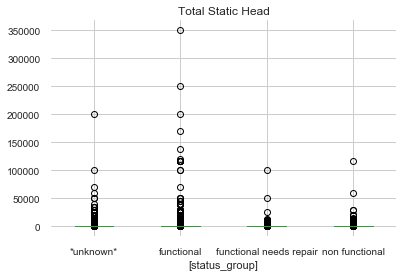

In [53]:
axes = dataset.boxplot(column=['amount_tsh'],by=['status_group']).set_title('Total Static Head')
fig = axes.get_figure()
fig.suptitle('')

<div class="alert alert-block alert-success">
There are alot of '0' values for amount of static head for working pumps which is an error. We will change this values to NaN and impute them as missing values. This is becuase it is not possible to have **'functional'** and **'functional needs repair'** pumps with zero value for static head.

The above variables were identified because they were numeric, however we will need to manually check if there are '0's as string under categories and idenfify if they are errors, missing values or valid inputs.

In [54]:
dataset.isin(['0']).sum(axis=0)[dataset.isin(['0']).sum(axis=0).ne(0)]

funder       980
installer    980
dtype: int64

In [55]:
dataset['permit'].value_counts()

True     48606
False    21851
Name: permit, dtype: int64

In [56]:
dataset.isin([0]).sum(axis=0)[dataset.isin([0]).sum(axis=0).ne(0)]

id                       1
amount_tsh           52049
gps_height           25649
longitude             2269
num_private          73299
district_code           27
population           26834
public_meeting        6346
permit               21851
construction_year    25969
dtype: int64

It is possible for district code to be 0, and **public_meeting** and **permit** are a boolean column thus having a zero value means false.

<div class="alert alert-block alert-success">
Tanzania is located between latitudes 1°S and 12°S and longitudes 29°E to 41°E. Thus a zero degree in longitude is an error or in this case considered a missing value. Moreover, there are locations that have specifically latitudes outside this range for Tanzania. These values will also be considered as missing values and imputed.

In [57]:
#The Values here are the zeros identified above
len(pd.DataFrame(dataset[(dataset['longitude'].astype('int', ordered=True)< 29) | (dataset['longitude'].astype('int', ordered=True)>41)]))

2269

In [58]:
len(pd.DataFrame(dataset[(dataset['latitude'].astype('int', ordered=True)> -1) | (dataset['latitude'].astype('int', ordered=True)<-12)]))

2277

<div class="alert alert-block alert-success">
There is no clear definition of what **num_private** means and 99% of the observations are zero thus we can ignore it from our model, as we wouldn't have meaningful interpretation. 

In [59]:
dataset[dataset['id']==0]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,data_set
9410,0,0.0,2012-11-13,Tasaf,0,TASAF,33.125828,-5.118154,Mratibu,0,...,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional,train


#### Checking Duplicates

We have no duplicated rows in our dataset.

In [60]:
len(pd.DataFrame(dataset[dataset["id"].duplicated()]))

0

## 3. Data Cleaning <a class="anchor" id="third-bullet"></a>

Following the finding above we will change the variables with zeros empty values below.   
- "amount_tsh"
- "population"
- "gps_height"
- "construction_year"
- "funder"
- "installer"
- "longitude"

In [61]:
dataset=dataset.drop(columns=['num_private'])

Below we replace all the zeros to NAs.

In [62]:
zero_cols = ['amount_tsh','population','gps_height','construction_year','funder','installer','longitude']
dataset[zero_cols] = dataset[zero_cols].replace({'0':np.nan, 0:np.nan})

Below we substring **date_recorded** to get **year_recorded** and then change the data type for **date_recorded** from catgory to date.

In [63]:
dataset['year_recorded'] = dataset['date_recorded'].str[:4]

In [64]:
dataset["date_recorded"] = dataset["date_recorded"].astype('datetime64[ns]') 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 42 columns):
id                       74250 non-null category
amount_tsh               22201 non-null float64
date_recorded            74250 non-null datetime64[ns]
funder                   68766 non-null object
gps_height               48601 non-null float64
installer                68738 non-null object
longitude                71981 non-null float64
latitude                 74250 non-null category
wpt_name                 74250 non-null category
basin                    74250 non-null category
subvillage               73780 non-null category
region                   74250 non-null category
region_code              74250 non-null category
district_code            74250 non-null category
lga                      74250 non-null category
ward                     74250 non-null category
population               47416 non-null float64
public_meeting           70095 non-null category
recorded_by

### 3.1. Outliers <a class="anchor" id="third1-bullet"></a>

Before imputing the missing values, first the outliers will be checked excluding the missing values to make sure don impute based on them. 

In [65]:
dataset.describe()

,amount_tsh,gps_height,longitude,population,construction_year
count,22201.000000,48601.000000,71981.000000,47416.000000,48281.000000
mean,1065.826474,1016.970803,35.148358,283.042623,1996.870943
std,5240.480449,613.127399,2.608924,564.413842,12.440524
min,0.200000,-90.000000,29.607122,1.000000,1960.000000
25%,50.000000,390.000000,33.277747,40.000000,1988.000000
50%,250.000000,1166.000000,35.007072,150.000000,2000.000000
75%,1000.000000,1497.000000,37.237383,328.000000,2008.000000
max,350000.000000,2777.000000,40.345193,30500.000000,2013.000000


In [66]:
nonan_dataset1=dataset[dataset['amount_tsh'].notna()]
nonan_dataset2=dataset[dataset['gps_height'].notna()]
nonan_dataset3=dataset[dataset['population'].notna()]

Text(0.5, 1.0, 'Population Around the Well')

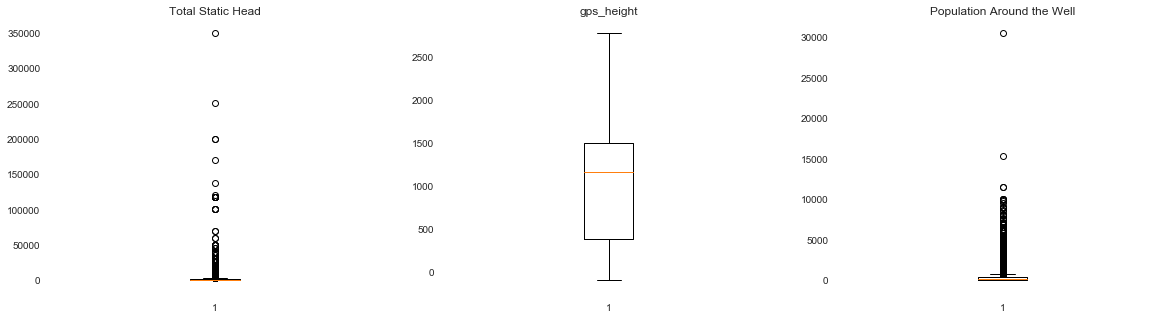

In [67]:
fig, axs = plt.subplots(1, 3, figsize = (20, 5))


axs[0].boxplot(nonan_dataset1['amount_tsh'])
axs[0].set_title('Total Static Head')
axs[1].boxplot(nonan_dataset2['gps_height'])
axs[1].set_title('gps_height')
axs[2].boxplot(nonan_dataset3['population'])
axs[2].set_title('Population Around the Well')

In [68]:
sub_dataset=dataset[['amount_tsh','population']]
Q1 = sub_dataset.quantile(0.25)
Q3 = sub_dataset.quantile(0.75)
IQR = Q3 - Q1

((sub_dataset < (Q1 - 1.5 * IQR)) | (sub_dataset > (Q3 + 1.5 * IQR))).sum()

amount_tsh    2058
population    3105
dtype: int64

Eventhough according to the quantile calculation we find several outliers in **amount_tsh** and **population**, we don't have enough information regarding the static head amount and what would be regarded as the maximum amount thus we can not assume that these values are errors or outliers. 
Similarly, with population surrounding the well could go as high as 30000 so we don't have enough justification with the amount of missing values that we have to regard these as outliers or errors. 

With binning we can create categories for this values so that out model can train and predict on them in the cases that they do come up.

### 3.2. Missing Values <a class="anchor" id="third2-bullet"></a>

In [69]:
NaNSummary=pd.DataFrame(dataset.isna().sum()[dataset.isna().sum().ne(0)])  #change ne
NaNSummary['missing count']=NaNSummary[0]
NaNSummary['proportion']=NaNSummary['missing count']/74250*100
# NaNSummary['proportion'].round()
del NaNSummary[0]

NaNSummary

,missing count,proportion
amount_tsh,52049,70.099663
funder,5484,7.385859
gps_height,25649,34.544108
installer,5512,7.423569
longitude,2269,3.055892
subvillage,470,0.632997
population,26834,36.140067
public_meeting,4155,5.595960
scheme_management,4846,6.526599
scheme_name,35258,47.485522


### 3.2.2. KMode Clustering <a class="anchor" id="third22-bullet"></a>

A variation of k-means, **k-modes** method, will be used for clustering. This is because the dataset is primarily categorical variables and calculating distance between categorical variables is not applicable unless dummified, this alternative is chosen. 

Clusters will be created in this method, by first excluding the features that have missing values then merge the new cluster column back with the found clusters. Then for each missing value we will use the mode in its respective cluster for that feature to impute it. 

The kmodes minimizes the sum of feature values differences within-cluster. We will set the initializer at 'random' so that the initial centroids will be picked at random and run it 10 times with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of cost.

To choose the number of clusters in kmode there isn't a good method to decide the optimal number, so to decided to compare between creating 3, 4 and 5 clusters and compare the best iterations in eachone using the cost and the cluster pr 

In [70]:
#Removing features that have empty values
dataset_clust=dataset.dropna(axis='columns')
del dataset_clust['data_set']
dataset_clust.shape

(74250, 29)

In [30]:
 random.seed(1)
#5 clusters
km1 = KModes(n_clusters=5, init='random', n_init=10, verbose=1)
cluster1 = km1.fit_predict(dataset_clust[1:])#exlude ID from variable to cluster based on
#6 clusters
km2 = KModes(n_clusters=6, init='random', n_init=10, verbose=1)
clusters2 = km2.fit_predict(dataset_clust)
#7 clusters
km3 = KModes(n_clusters=7, init='random', n_init=10, verbose=1)
cluster3 = km3.fit_predict(dataset_clust)
#8 clusters
km4 = KModes(n_clusters=8, init='random', n_init=10, verbose=1)
cluster4 = km4.fit_predict(dataset_clust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 21301, cost: 1059353.0
Run 1, iteration: 2/100, moves: 3562, cost: 1059358.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 14607, cost: 1052265.0
Run 2, iteration: 2/100, moves: 3633, cost: 1048862.0
Run 2, iteration: 3/100, moves: 517, cost: 1048862.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 7915, cost: 1016687.0
Run 3, iteration: 2/100, moves: 609, cost: 1016687.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 11513, cost: 1035117.0
Run 4, iteration: 2/100, moves: 4147, cost: 1034951.0
Run 4, iteration: 3/100, moves: 228, cost: 1034951.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 17391, cost: 1060580.0
Run 5

Run 1, iteration: 3/100, moves: 755, cost: 992593.0
Run 1, iteration: 4/100, moves: 12, cost: 992593.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 16851, cost: 1004078.0
Run 2, iteration: 2/100, moves: 5073, cost: 1000973.0
Run 2, iteration: 3/100, moves: 2601, cost: 1000893.0
Run 2, iteration: 4/100, moves: 39, cost: 1000893.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 26535, cost: 978246.0
Run 3, iteration: 2/100, moves: 8146, cost: 971922.0
Run 3, iteration: 3/100, moves: 2148, cost: 970939.0
Run 3, iteration: 4/100, moves: 270, cost: 970939.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 25948, cost: 998406.0
Run 4, iteration: 2/100, moves: 7241, cost: 994786.0
Run 4, iteration: 3/100, moves: 2692, cost: 994416.0
Run 4, iteration: 4/100, moves: 284, cost: 994416.0
Init: initializing

In [31]:
# Cluster 1 Print the cluster centroids
centroids1=pd.DataFrame(km1.cluster_centroids_)
centroids1

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,12,2011-03-30,-2e-08,Shuleni,Rufiji,Mbeya,12,2,Njombe,Usuka,...,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,2011
1,0,2012-10-22,-2e-08,none,Lake Victoria,Shinyanga,17,1,Bariadi,Nkungulu,...,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,2011
2,2,2011-03-12,-2e-08,Shuleni,Wami / Ruvu,Dodoma,1,1,Bagamoyo,Chalinze,...,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional,2013
3,6,2013-01-24,-2e-08,Shuleni,Lake Victoria,Shinyanga,17,3,Kahama,Mishamo,...,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional,2013
4,3,2011-03-15,-2e-08,none,Pangani,Kilimanjaro,3,3,Njombe,Igosi,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011


In [32]:
# Cluster 2 Print the cluster centroids
centroids2=pd.DataFrame(km2.cluster_centroids_)
centroids2

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,22,2013-01-30,-2e-08,Shuleni,Wami / Ruvu,Singida,13,1,Bagamoyo,Chalinze,...,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional,2013
1,3,2011-03-15,-2e-08,none,Pangani,Iringa,11,1,Njombe,Igosi,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011
2,1,2012-10-22,-2e-08,none,Lake Victoria,Shinyanga,17,1,Bariadi,Chinamili,...,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,2011
3,7,2011-03-16,-2e-08,Shuleni,Rufiji,Morogoro,5,3,Kilombero,Ifakara,...,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,2011
4,6,2013-01-24,-2e-08,Shuleni,Lake Victoria,Shinyanga,17,3,Kahama,Mishamo,...,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional,2013
5,114,2011-03-30,-2e-08,Shuleni,Rufiji,Mbeya,12,2,Njombe,Usuka,...,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,2011


In [33]:
# Cluster 3 Print the cluster centroids
centroids3=pd.DataFrame(km3.cluster_centroids_)
centroids3

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,6,2013-01-24,-2e-08,Shuleni,Lake Victoria,Shinyanga,17,3,Kahama,Mishamo,...,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional,2013
1,12,2013-03-04,-2e-08,Shuleni,Pangani,Arusha,2,2,Arusha Rural,Nduruma,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,non functional,2013
2,5,2011-03-19,-2e-08,Shuleni,Wami / Ruvu,Pwani,1,1,Bagamoyo,Chalinze,...,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional,2011
3,20,2011-03-30,-2e-08,Shuleni,Rufiji,Mbeya,12,2,Njombe,Usuka,...,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,2011
4,3,2013-02-26,-2e-08,Shuleni,Pangani,Kilimanjaro,3,4,Moshi Rural,Siha Kati,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2013
5,0,2013-01-30,-2e-08,none,Lake Victoria,Shinyanga,17,1,Bariadi,Nkungulu,...,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,2011
6,1,2011-03-15,-2e-08,none,Lake Nyasa,Iringa,11,4,Njombe,Igosi,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011


In [37]:
# Cluster 3 Print the cluster centroids
centroids4=pd.DataFrame(km4.cluster_centroids_)
centroids4

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1,2011-03-15,-2e-08,none,Lake Nyasa,Iringa,11,4,Njombe,Igosi,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011
1,7,2013-03-04,-2e-08,Shuleni,Pangani,Arusha,2,2,Arusha Rural,Nduruma,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,non functional,2013
2,2,2011-03-19,-2e-08,Shuleni,Wami / Ruvu,Pwani,1,1,Bagamoyo,Chalinze,...,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional,2011
3,6,2013-01-24,-2e-08,Shuleni,Lake Victoria,Shinyanga,17,3,Kahama,Mishamo,...,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional,2013
4,25,2013-01-30,-2e-08,Shuleni,Lake Victoria,Shinyanga,17,1,Bariadi,Chinamili,...,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,2013
5,13,2011-03-16,-2e-08,none,Lake Victoria,Mwanza,19,4,Mbozi,Ihanda,...,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,2011
6,20,2011-03-30,-2e-08,Shuleni,Rufiji,Mbeya,12,2,Mbarali,Rujewa,...,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,2011
7,38,2013-03-20,-2e-08,Shuleni,Internal,Shinyanga,17,1,Kishapu,Endabash,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2013


The 8 cluster was the one with the least cost and more unique differentiation between features of the cluster centeroids.

*The run for 3 clusters and 4 clusters were removed from script above only to make script less croweded.*

In [71]:
dataset_clust['cluster'] = pd.Series(cluster4, index=dataset_clust.index)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
dataset_clust['cluster'].value_counts()

0    15957
5    10782
2     9791
1     9725
4     9314
6     8953
3     7711
7     2017
Name: cluster, dtype: int64

Add the cluster created above to original dataframe.

In [76]:
dataset = pd.merge(dataset,
                 dataset_clust[['id','cluster']],
                 on='id')
dataset.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,...,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,data_set,year_recorded,cluster_x,cluster_y,cluster
0,69572,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,Lake Nyasa,...,spring,groundwater,communal standpipe,communal standpipe,functional,train,2011,0,0,0
1,8776,NaN,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,...,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,train,2013,1,1,1
2,34310,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,...,dam,surface,communal standpipe multiple,communal standpipe,functional,train,2013,0,0,0
3,67743,NaN,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,...,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,train,2013,2,2,2
4,19728,NaN,2011-07-13,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,...,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,train,2011,7,7,7


### 3.2.3. Missing Value Imputation <a class="anchor" id="third23-bullet"></a>

Below the na each feature are filled with the mode of the cluster that it belongs to. 

In [80]:
f = lambda x: x.median() if np.issubdtype(x.dtype, np.number) else x.mode().iloc[0]
dataset_f = dataset.fillna(dataset.groupby('cluster').transform(f))

## 4. Data Exploration <a class="anchor" id="forth-bullet"></a>

### 4.1. More Data Cleaning and Transformations <a class="anchor" id="forth1-bullet"></a>

0        28
1       471
2      3224
3      1812
4      1484
5      7142
6     16700
7     29885
8     10339
9      1717
10     1140
11      235
12       30
13       43
Name: bin_amount_tsh, dtype: int64


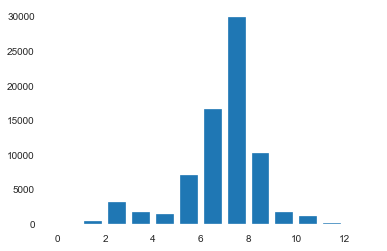

In [81]:
bat_bins = [0, 3, 5, 15, 20, 45, 50, 300, 500, 1500, 3000, 8000, 20000, 30000, np.inf]
bat_labels = list(range(len(bat_bins) - 1))

dataset_f['bin_amount_tsh'] = pd.cut(dataset_f['amount_tsh'],
                                  bins = bat_bins, 
                                  labels = bat_labels)
#Rename the Bins

plt.hist(dataset_f["bin_amount_tsh"], bins = bat_labels, rwidth = 0.75)
print(dataset_f["bin_amount_tsh"].value_counts().sort_index())

0     8782
1    16894
2    27730
3    15042
4     4003
5     1799
Name: bin_population, dtype: int64


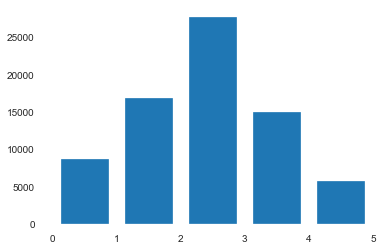

In [82]:
bp_bins = [0, 1, 100, 250, 500, 1000, np.inf]
bp_labels = list(range(len(bp_bins) - 1))

#Rename the Bins

dataset_f['bin_population'] = pd.cut(dataset_f['population'],
                                  bins = bp_bins, 
                                  labels = bp_labels)

plt.hist(dataset_f["bin_population"], bins = bp_labels, rwidth = 0.75)
print(dataset_f["bin_population"].value_counts().sort_index())

### Train Test Split

<div class="alert alert-block alert-success">
The train and test will be separated before the next steps as the data cleaning is compeleted. It will be split using the annotation added under column **data_set** and that column will be removed as it no longer will be used. 

In [84]:
dataset_fb= dataset_f
trainset=dataset_fb[dataset_fb['data_set']=='train']
testset=dataset_fb[dataset_fb['data_set']=='test']
trainset.shape,testset.shape

### 4.2. Dataset Balance <a class="anchor" id="forth2-bullet"></a>

As established [here](#imbalance-bullet), there is a class imbalance 
occurring in datasets with a disproportionate ratio of observations in each class. This will make our model biased as it learns more on the more frequently occuring classes. 
To handle this disproportionality we will test the two options of up-sampling our minority class and down-sampling our majority class. To choose which one is better we will fit the prediction to a Logistic Regression and compare the performance of each method.

### 4.2.1. Up-Sample Minority Class

### 4.2.1. Down-Sample Majority Class